An extension to the information-matching is to use it in an active learning loop.
In this case, we simultaneously optimize the training configurations (i.e. data) and the model parameters.
This is especially important when we don't have a good prior for the parameters and the parameters vary significantly with new data.

A common step-by-step workflow looks like the following:

1. Define the model, the candidate configurations or data, and the target QoIs we want to predict and their precision.
2. Choose an initial parameter values and initialize containers to store the optimal weights and the reference data.
3. Compute the FIM for each candidate configuration and the FIM of the target quantities with this parameter values.
4. Solve a convex optimization problem to match the FIMs.
5. Update the optimal weights.
For each configuration, compare the optimal weight in the container with one obtained from step 4 and store the larger one.
6. Check for convergence, i.e., if the change in weights in the subsequent iterations is less than some tolerance.
If not converged, go to steps 7 and 8; if converged got to step 9.
7. For each optimal configuration, generate the reference data.
8. Train the model using the optimal configuration with the corresponding reference data and optimal weights.
Use the optimal parameter and go back to step 2.
9. Propagate the uncertainties to the target quantities.

In [1]:
import numpy as np
from scipy.optimize import least_squares

from information_matching.fim import FIM_nd
from information_matching.convex_optimization import ConvexOpt, compare_weights
from information_matching.utils import check_convergence

# For plotting
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")

# Setup - Model, candidates, and target

As a toy example, we will consider the weather modeling problem.
We look at the data of monthly averaged atmospheric pressure difference between Easter Island and Darwin, Australia.
The data contains an annual cycle and other cycles that correspond to the El Niño and Southern Oscillation.

For this example, we target to precisely predict the atmospheric pressure in the 15th year within 2~atm.
As the candidate configurations, we will use the annual measurement of these 14 years worth of atmospheric.
Thus, we can phrase the problem as finding the data of which years that contain the most information to predict the pressure in the 15th year.

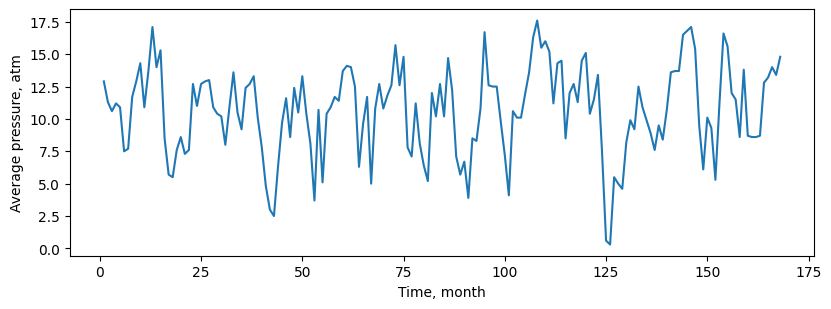

In [2]:
# Load the atmospheric pressure data
data = np.loadtxt("ENSO.txt")
time, press = data.T

# Plot the data
plt.figure(figsize=(9.6, 3.2))
plt.plot(time, press)
plt.xlabel("Time, month")
plt.ylabel("Average pressure, atm")
plt.show()

We model this phenomena with the following model as a function of time in month:
\begin{equation}
    \begin{aligned}
        y(t; \theta) =&~ \theta_1 +
            \theta_2 \cos(2\pi t/12) + \theta_3 \sin(2\pi t/12) + \\
            &~ \theta_5 \cos(2\pi t/\theta_4) + \theta_6 \sin(2\pi t/\theta_4) + \\
            &~ \theta_8 \cos(2\pi t/\theta_7) + \theta_9 \sin(2\pi t/\theta_7).
    \end{aligned}
\end{equation}
Notice that the first two Fourier terms with period of 12 months to capture the annual cycle.
Unlike in the OED case, we will try to infer all the parameters of this model.

In [3]:
# Defining the model.
# The model take parameter array as the first input and output a prediction array
def y(theta, t=time):
    """Model"""
    th1, th2, th3, th4, th5, th6, th7, th8, th9 = theta

    term1 = th1
    term2 = th2 * np.cos(2 * np.pi * t / 12)
    term3 = th3 * np.sin(2 * np.pi * t / 12)
    term4 = th5 * np.cos(2 * np.pi * t / th4)
    term5 = th6 * np.sin(2 * np.pi * t / th4)
    term6 = th8 * np.cos(2 * np.pi * t / th7)
    term7 = th9 * np.sin(2 * np.pi * t / th7)
    return term1 + term2 + term3 + term4 + term5 + term6 + term7


# Additionally, define a residual or loss function that we will use to train the model.
# This function should be able to use the optimal configurations and weights.
def residuals(theta, config_weights):
    """Use this function to train the model and get the optimal parameters."""
    res = []
    for config_name, weight in config_weights.items():
        conf_time = configs[config_name]["time"]
        reference = press[conf_time.astype(int) - 1]
        predictions = y(theta, conf_time)
        res = np.append(res, weight * (reference - predictions))
    return res

In [4]:
# Candidate configurations
configs = {
    f"year_{ii+1}": {"time": tlist} for ii, tlist in enumerate(time.reshape((-1, 12)))
}

# Target predictions
time_target = np.arange(12 * 14, 12 * 15) + 1
std_target = 2  # Target uncertainty of the target prediction

# Active learning loop

The final active learning result can depend on the initial parameters we use.
Thus, when possible, we should try to have better initial parameter guess.
For example, for this problem, the first parameter can be interpreted as the average pressure.
Parameters 4 and 7 seems to be the other two dominant periods, other than the annual period that has already been hard-coded.
The other parameters correspond to the variation for each period.

From looking at the plot of the data, we can make an educated guess for these parameters.
For example, the average pressure seems to be about 10.
Then, we might guess that the other dominant periods are 2 and 3 years.
Then, the pressure variation in each period seems to be about 2.5~atm.
Thus, we will use these values as our initial parameter guess.

Note: Alternatively, we can run multiple active learning loops, each with different initial parameter values, and pick the "best" one among these runs.

In [5]:
# Choose an initial parameter value
theta = np.array([10, 2.5, 2.5, 24, 2.5, 2.5, 36, 2.5, 2.5])
nparams = len(theta)

# Initialize the container to store the optimal weights. For this case, the reference
# data are already available for all time points. However, in other cases, we might
# also need to initialize a container to store the reference data.
opt_configs = {}

# Iteration
iteration = 0  # Keep track on how many iterations
while True:
    # Compute the FIMs of the candidate configurations and the target FIM
    # FIMs of the candidate configurations
    fim_configs = {
        config_id: FIM_nd(y)(theta, t=config_info["time"])
        for config_id, config_info in configs.items()
    }
    # Target FIM
    fim_target = FIM_nd(y)(theta, t=time_target) / std_target**2

    # Solve the convex optimization to find the optimal configurations and weights
    cvxopt = ConvexOpt(fim_target, fim_configs)
    cvxopt.solve()
    # These how we get the optimal results
    current_opt_configs = cvxopt.get_config_weights()

    # Compare the weights and update the overall optimal weights
    old_opt_configs = opt_configs.copy()  # Cache the result from preevious iteration
    opt_configs = compare_weights(opt_configs, current_opt_configs)

    # Check convergence
    converged = check_convergence(old_opt_configs, opt_configs)
    if converged:
        print(f"Information-matching AL converges in {iteration} iterations")
        print("Optimal parameters:", theta)
        break
    else:
        # In many cases, we will generate the training data in this step, and store
        # them in the reference data container. However, for this example, we already
        # have all the training data, so we will skip this process.
        # Train the model using the optimal configurations and weights
        lstsq_opt = least_squares(residuals, theta, method="lm", args=(opt_configs,))
        theta = lstsq_opt.x  # Update the parameters
        iteration += 1

Strange behavior : primal < dual :: line 158 in sdpa_solve.cpp


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Strange behavior : primal < dual :: line 158 in sdpa_solve.cpp


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Strange behavior : primal < dual :: line 158 in sdpa_solve.cpp


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Strange behavior : primal < dual :: line 158 in sdpa_solve.cpp


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Strange behavior : primal < dual :: line 158 in sdpa_solve.cpp


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Strange behavior : primal < dual :: line 158 in sdpa_solve.cpp
Information-matching AL converges in 5 iterations
Optimal parameters: [11.46628738  3.19599124 -0.29270336 22.03022171 -0.59053741  0.3803093
 34.56419428  0.33813147  1.98151435]


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# Follow-up analysis

At the end of this active learning loop, we will obtain:
1. An optimal model
2. Optimal training configurations and their labels or reference values
3. Optimal weights for these configurations, which dictate the target precisions to achieve when collecting the labels

In [6]:
# As the first step of the analysis, let's just list the optimal configurations and
# their weights
# Sort the year
sorted_config = sorted(list(opt_configs), key=lambda x: int(x.split('_')[1]))

print("Optimal configuration and weights:")
print("Configuration \t Weight \t Standard deviation")
for config in sorted_config:
    weight = opt_configs[config]
    print(f"{config}  \t {weight:0.4f} \t {1/np.sqrt(weight):0.4f}")

Optimal configuration and weights:
Configuration 	 Weight 	 Standard deviation
year_1  	 0.0703 	 3.7714
year_2  	 0.4043 	 1.5728
year_3  	 0.1602 	 2.4982
year_6  	 0.0597 	 4.0913
year_9  	 0.5913 	 1.3005
year_10  	 0.2488 	 2.0047
year_11  	 0.0834 	 3.4629
year_12  	 0.3721 	 1.6393
year_13  	 0.2161 	 2.1514
year_14  	 0.4052 	 1.5710


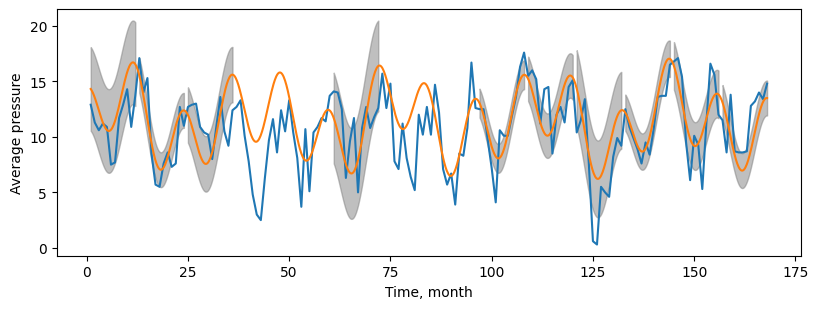

In [7]:
# Then, we can compare the optimal model and the data by plotting them. Additionally,
# for each optimal configuration, we add the optimal weight as target errorbar we need
# to achieve when collecting those data.
plt.figure(figsize=(9.6, 3.2))
# Plot the data
plt.plot(time, press)
# Plot the best model
tfine = np.linspace(*time[[0, -1]], 1000)
plt.plot(tfine, y(theta, tfine))

# Plot the target data precision of the optimal configurations
for config, weight in opt_configs.items():
    std_config = 1 / np.sqrt(weight)
    tlist = configs[config]["time"]
    tfine_config = np.linspace(*tlist[[0, -1]], 100)
    preds_config = y(theta, tfine_config)
    plt.fill_between(
        tfine_config,
        preds_config - std_config,
        preds_config + std_config,
        color="gray",
        alpha=0.5,
    )

plt.xlabel("Time, month")
plt.ylabel("Average pressure")
plt.show()

It is interesting to see that in order to precisely predicting the average pressure in the 15th year, we don't only need the data in the last few years, but also in the first few years and some time in between.
This visualization also illustrate how precise we need to collect the data in those years, which provide a useful insight.
Finally, by the information-matching theorem, these data should contain enough information to constrain the predictions in the 15th year within 2~atm.
We can check this by propagating the uncertainty using the FIM.

In [8]:
# Propagate the uncertainty to the target QoIs
# First, compute the covariance of the parameters from the inverse of the FIM
# computed using these optimal configurations and their weights.
opt_fim_configs = np.zeros((nparams, nparams))
for config, weight in opt_configs.items():
    opt_fim_configs += fim_configs[config] * weight
cov_params = np.linalg.inv(opt_fim_configs)  # Parameter covariance

# Propagate the uncertainty to the target predictions of pressure in the 15th year
jac_target = FIM_nd(y).Jacobian(theta, t=time_target)
cov_target = jac_target @ cov_params @ jac_target.T
opt_std_target = np.sqrt(np.diag(cov_target))
print("Standard deviation of the predictions in the 15th year:")
print(opt_std_target)
print(
    "Uncertainty from optimal data less than the target:",
    np.all(opt_std_target < std_target),
)

Standard deviation of the predictions in the 15th year:
[0.62340082 0.65709766 0.66838327 0.65477272 0.62460473 0.59640967
 0.59040816 0.61295268 0.65020218 0.68003881 0.68629846 0.66490394]
Uncertainty from optimal data less than the target: True


As expected, the uncertainty of the target from the optimal configurations and weights are smaller than the predefined target uncertainty.
Another way to present it is to plot the target QoIs.
In the following, we plot the predictions (red curve) with the target uncertainty to achieve (red envelop) and the uncertainty from the optimal configurations (red error bars).
We can clearly see that the uncertainty from the optimal configurations are smaller than the target uncertainty to achieve.

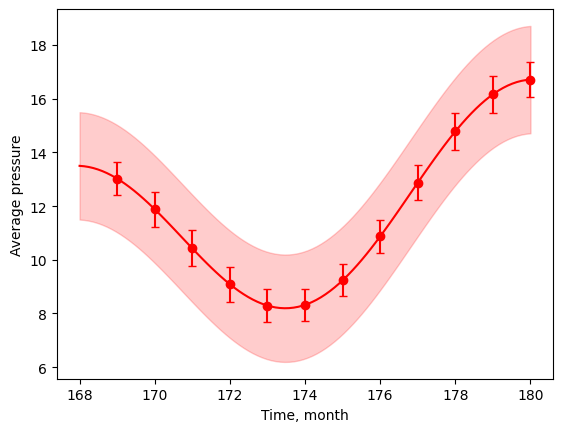

In [9]:
plt.figure()
# Plot the target predictions
tfine_target = np.linspace(12 * 14, 12 * 15, 100)
preds_target = y(theta, tfine_target)
plt.plot(tfine_target, preds_target, c="r")
# Plot the target uncertainty that we want to achieve
plt.fill_between(
    tfine_target,
    preds_target - std_target,
    preds_target + std_target,
    color="r",
    alpha=0.2,
)
# Plot the uncertainty obtained from the optimal configurations and weights
plt.errorbar(
    time_target,
    y(theta, time_target),
    opt_std_target,
    fmt="o",
    color="r",
    capsize=3,
)

plt.xlabel("Time, month")
plt.ylabel("Average pressure")
plt.show()